# Classifying data in moon-shaped clusters using a basic neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(40)

# Making some data with `make_moons`

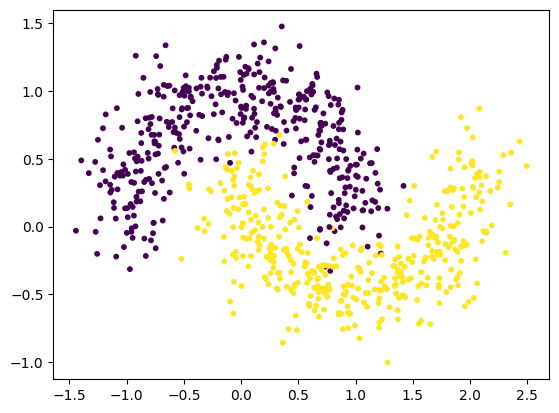

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples = 1000, noise = 0.2, random_state = 42)
X = torch.from_numpy(X)
y = torch.from_numpy(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=10)

# Setting up the model, loss function and optimizer
I also tried with ReLU but the decision boundary was more jagged so tanh seemed to represent the data better

In [3]:
# Define the model
class model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer_stack = nn.Sequential (
        nn.Linear(in_features=2, out_features=5),
        nn.Tanh(),
        nn.Linear(in_features=5, out_features=5),
        nn.Tanh(),
        nn.Linear(in_features=5, out_features=1),
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

In [4]:
#Make model, loss function, optimizer
MoonClassifier = model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(MoonClassifier.parameters(), lr=0.1)

def accuracy_fn(pred, true):
  return 100*sum(pred == true) / len(true)

# Correcting datatypes and moving to GPU if possible

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = X_train.type(torch.float32).to(device)
y_train = y_train.type(torch.float32).to(device)
X_test = X_test.type(torch.float32).to(device)
y_test = y_test.type(torch.float32).to(device)

MoonClassifier.to(device)
device

'cuda'

# Training

In [6]:
epochs = 120

#These allow us to plot the losses afterwards
train_losses = []
test_losses = []

for epoch in range(epochs):

  MoonClassifier.train() #Training mode
  train_logits = MoonClassifier(X_train).squeeze() #compute logits
  train_pred = torch.round(torch.sigmoid(train_logits)) #turn into predictions
  train_loss = loss_fn(train_logits, y_train) #compute loss
  train_acc = accuracy_fn(pred=train_pred, true=y_train) #compute accuracy

  optimizer.zero_grad() #zero the gradients

  train_loss.backward() #compute the gradients

  optimizer.step() #update the weights

  if (epoch+1) % 5 ==0:
    MoonClassifier.eval() #evaluation mode
    with torch.inference_mode():
      test_logits = MoonClassifier(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(pred=test_pred, true=y_test)
      
      # Append losses to the lists so we can plot them against epochs after
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 5 | Train Loss: 0.36509, Train Acc: 84.00% | Test Loss: 0.36478, Test Acc: 84.50%
Epoch: 10 | Train Loss: 0.32841, Train Acc: 86.75% | Test Loss: 0.38011, Test Acc: 84.50%
Epoch: 15 | Train Loss: 0.31989, Train Acc: 85.88% | Test Loss: 0.33696, Test Acc: 86.00%
Epoch: 20 | Train Loss: 0.30456, Train Acc: 87.00% | Test Loss: 0.32105, Test Acc: 85.00%
Epoch: 25 | Train Loss: 0.29894, Train Acc: 86.62% | Test Loss: 0.31671, Test Acc: 85.50%
Epoch: 30 | Train Loss: 0.28480, Train Acc: 86.75% | Test Loss: 0.30723, Test Acc: 85.00%
Epoch: 35 | Train Loss: 0.28332, Train Acc: 87.00% | Test Loss: 0.30756, Test Acc: 86.00%
Epoch: 40 | Train Loss: 0.27793, Train Acc: 86.88% | Test Loss: 0.30211, Test Acc: 86.00%
Epoch: 45 | Train Loss: 0.27539, Train Acc: 87.12% | Test Loss: 0.29511, Test Acc: 86.50%
Epoch: 50 | Train Loss: 0.27263, Train Acc: 86.75% | Test Loss: 0.29529, Test Acc: 85.50%
Epoch: 55 | Train Loss: 0.26978, Train Acc: 87.12% | Test Loss: 0.29182, Test Acc: 86.50%
Epoch: 60 |

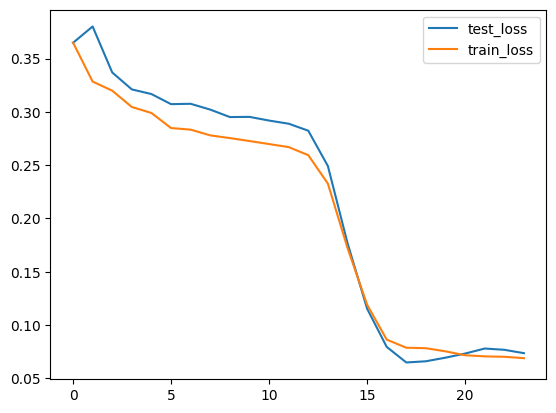

In [7]:
plt.plot(test_losses, label="test_loss")
plt.plot(train_losses, label="train_loss")
plt.legend()

# Visualising the decision boundary

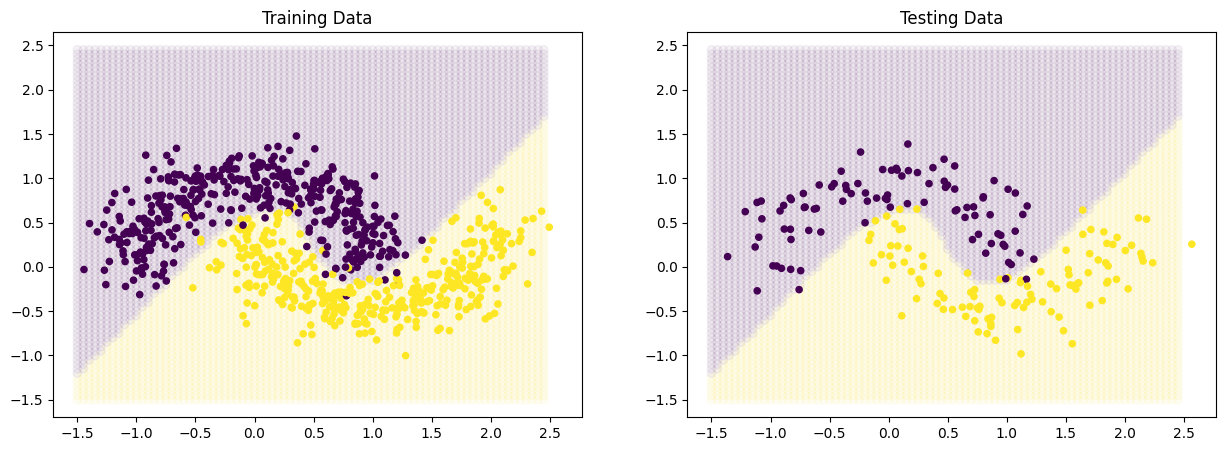

In [8]:
# Making a bunch of points to display the decision boundary
dec_x = torch.cartesian_prod(torch.arange(-1.5, 2.5, 0.05), torch.arange(-1.5, 2.5, 0.05)).to(device)
MoonClassifier.eval()
with torch.inference_mode():
  dec_y = MoonClassifier(dec_x).squeeze()

# Moving data over to cpu to plot it:
dec_x = dec_x.to('cpu')
dec_y = dec_y.to('cpu')
X_train = X_train.to('cpu')
y_train = y_train.to('cpu')
X_test = X_test.to('cpu')
y_test = y_test.to('cpu')

# Plotting data
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)

f.set_size_inches(15, 5)
ax1.set_title('Training Data')
ax1.scatter(dec_x[:,0], dec_x[:,1], c=torch.round(torch.sigmoid(dec_y)),alpha=0.05)
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20)

ax2.set_title('Testing Data')
ax2.scatter(dec_x[:,0], dec_x[:,1], c=torch.round(torch.sigmoid(dec_y)),alpha=0.05)
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test, s=20)